In [1]:
from sentence_transformers import SentenceTransformer, util
import json
from statistics import mean
import chardet


c:\Users\nerea\anaconda3\envs\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_json_auto(file_path):
    with open(file_path, "rb") as f:
        raw = f.read()
    encoding = chardet.detect(raw)["encoding"]
    return json.loads(raw.decode(encoding))

In [4]:
ground_truth = load_json_auto("C:\\Users\\nerea\\Documents\\MasterDTU\\masterThesis\\masterThesis\\testing\\gt.json")
retrieved = load_json_auto("C:\\Users\\nerea\\Documents\\MasterDTU\\masterThesis\\masterThesis\\testing\\retrieval_results_dense.json")

In [5]:
# Helper to get retrieved windows by question
def get_retrieved_windows(question, retrieved_data):
    for q, items in retrieved_data.items():
        if q.strip().lower() == question.strip().lower():
            return [i["metadata"]["window"] for i in items if "metadata" in i and "window" in i["metadata"]]
    return []


In [6]:
# Load the same embedding model your RAG uses (important for consistent results)
model = SentenceTransformer("all-MiniLM-L6-v2")


In [7]:
results = []
threshold = 0.4

In [8]:
for gt_entry in ground_truth:
    question = gt_entry["question"]
    gt_segments = [seg["text"] for seg in gt_entry["ground_truth_segments"]]
    retrieved_windows = get_retrieved_windows(question, retrieved)

    if not retrieved_windows:
        continue

    # Encode embeddings
    gt_emb = model.encode(gt_segments, convert_to_tensor=True)
    retrieved_emb = model.encode(retrieved_windows, convert_to_tensor=True)

    # Compute cosine similarity matrix
    sim_matrix = util.cos_sim(gt_emb, retrieved_emb).cpu().numpy()

    # For each GT, find the best retrieved window
    gt_hits = [max(row) for row in sim_matrix]
    retrieved_hits = [max(col) for col in sim_matrix.T]

    # Determine hits by threshold
    TP = sum(1 for s in retrieved_hits if s > threshold)
    FP = sum(1 for s in retrieved_hits if s <= threshold)
    FN = sum(1 for s in gt_hits if s <= threshold)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    avg_similarity = mean(gt_hits)
    results.append({
        "question": question,
        "avg_similarity": avg_similarity,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

In [9]:
# Print
for r in results:
    print(f"Q: {r['question']}")
    print(f"  Avg similarity: {r['avg_similarity']:.3f}")
    print(f"  Precision: {r['precision']:.2f}")
    print(f"  Recall: {r['recall']:.2f}")
    print(f"  F1: {r['f1']:.2f}\n")

Q: Which solution should a researcher use if they want High accuracy and data export?
  Avg similarity: 0.354
  Precision: 1.00
  Recall: 0.20
  F1: 0.33

Q: Which solution should I use if I want compatibility with analysis tools like matlab?
  Avg similarity: 0.394
  Precision: 1.00
  Recall: 0.33
  F1: 0.50

Q: Which solution is better for a university group? They want to use this solution in different applications.
  Avg similarity: 0.360
  Precision: 1.00
  Recall: 0.33
  F1: 0.50

Q: I need a solution that complies with noise regulations and does automated reports.
  Avg similarity: 0.643
  Precision: 1.00
  Recall: 1.00
  F1: 1.00

Q: Which solution should I use to measure noise levels in a factory floor?
  Avg similarity: 0.505
  Precision: 1.00
  Recall: 1.00
  F1: 1.00

Q: Which solution should I use to conduct noise impact assessments? I need GPS tagging and the device to be weatherproof.
  Avg similarity: 0.289
  Precision: 0.00
  Recall: 0.00
  F1: 0.00

Q: I want to monito

C:\Users\nerea\AppData\Local\Temp\ipykernel_25988\3046549112.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


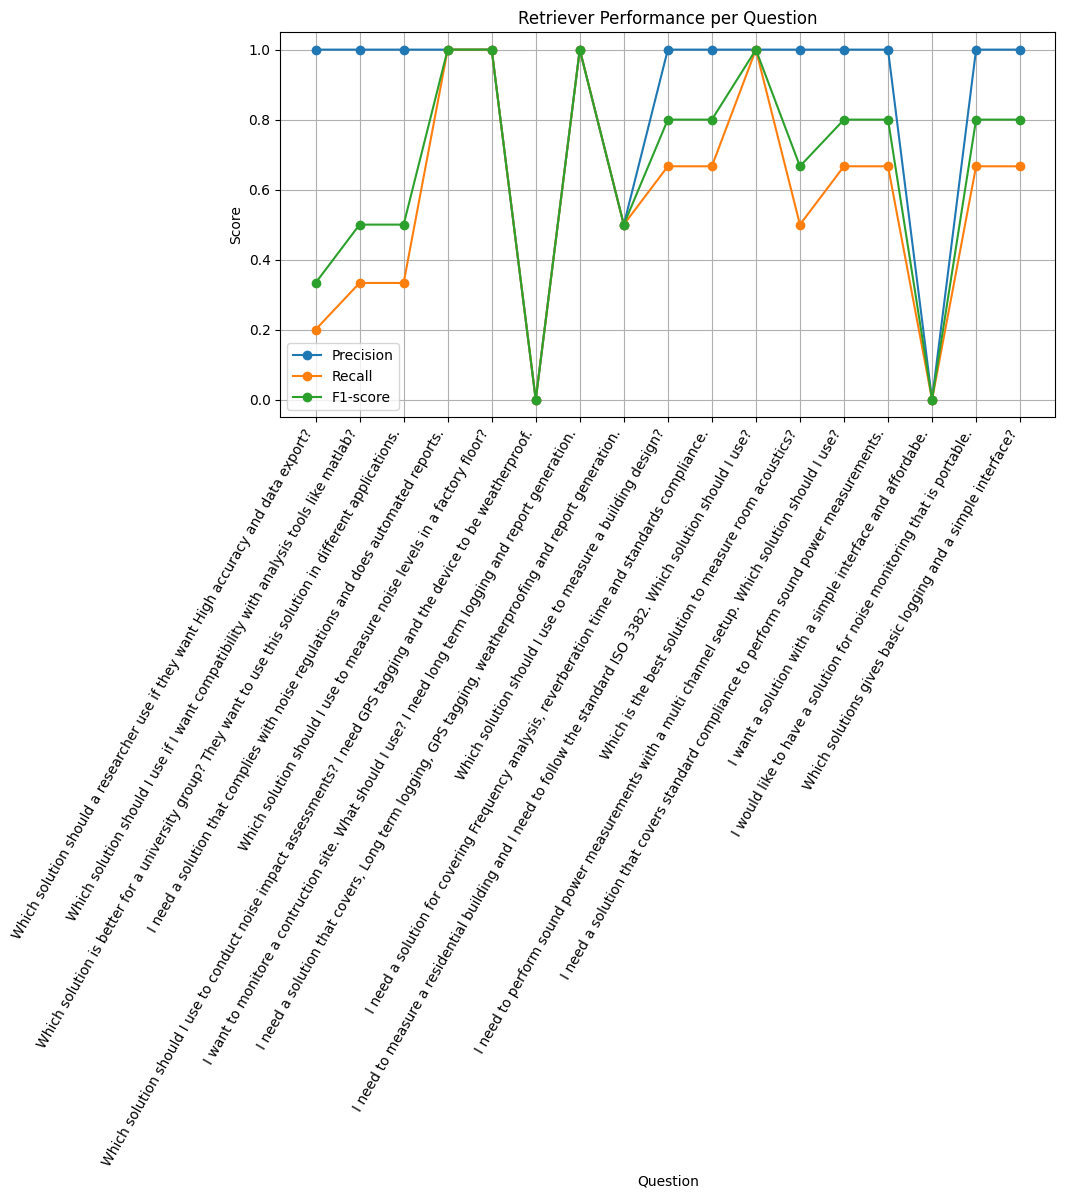

In [11]:
import matplotlib.pyplot as plt

questions = [r["question"] for r in results]
precision = [r["precision"] for r in results]
recall = [r["recall"] for r in results]
f1 = [r["f1"] for r in results]

plt.figure(figsize=(10, 5))
plt.plot(questions, precision, marker='o', label='Precision')
plt.plot(questions, recall, marker='o', label='Recall')
plt.plot(questions, f1, marker='o', label='F1-score')

plt.xticks(rotation=60, ha='right')
plt.xlabel("Question")
plt.ylabel("Score")
plt.title("Retriever Performance per Question")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


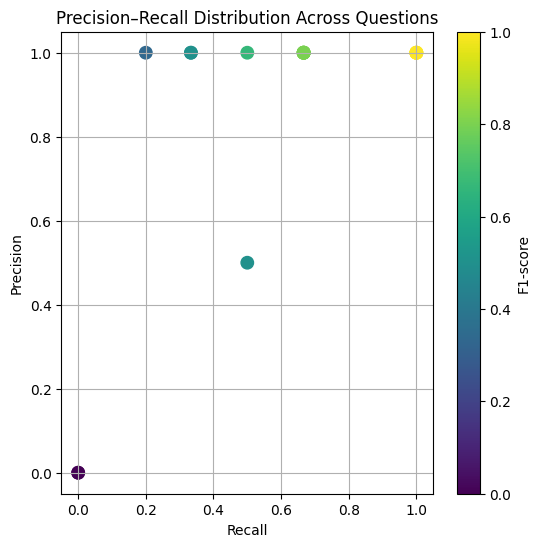

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(recall, precision, c=f1, cmap='viridis', s=80)
plt.colorbar(label='F1-score')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Distribution Across Questions")
plt.grid(True)
plt.show()

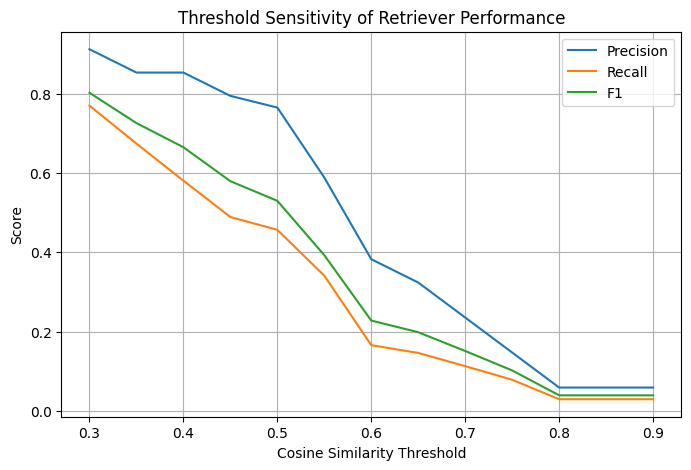

In [13]:
import numpy as np
thresholds = np.linspace(0.3, 0.9, 13)  # from 0.3 to 0.9
scores = []

for t in thresholds:
    precisions, recalls, f1s = [], [], []
    for gt_entry in ground_truth:
        question = gt_entry["question"]
        gt_segments = [seg["text"] for seg in gt_entry["ground_truth_segments"]]
        retrieved_windows = get_retrieved_windows(question, retrieved)
        if not retrieved_windows:
            continue
        gt_emb = model.encode(gt_segments, convert_to_tensor=True)
        retrieved_emb = model.encode(retrieved_windows, convert_to_tensor=True)
        sim_matrix = util.cos_sim(gt_emb, retrieved_emb).cpu().numpy()
        gt_hits = [max(row) for row in sim_matrix]
        retrieved_hits = [max(col) for col in sim_matrix.T]

        TP = sum(1 for s in retrieved_hits if s > t)
        FP = sum(1 for s in retrieved_hits if s <= t)
        FN = sum(1 for s in gt_hits if s <= t)

        p = TP / (TP + FP) if (TP + FP) > 0 else 0
        r = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

    scores.append({
        "threshold": t,
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "f1": np.mean(f1s)
    })

plt.figure(figsize=(8, 5))
plt.plot([s["threshold"] for s in scores], [s["precision"] for s in scores], label="Precision")
plt.plot([s["threshold"] for s in scores], [s["recall"] for s in scores], label="Recall")
plt.plot([s["threshold"] for s in scores], [s["f1"] for s in scores], label="F1")
plt.xlabel("Cosine Similarity Threshold")
plt.ylabel("Score")
plt.title("Threshold Sensitivity of Retriever Performance")
plt.legend()
plt.grid(True)
plt.show()
